## Importing requires python packages

In [1]:
import pandas as pd
import itertools
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.text import Text
import textwrap
import matplotlib.patches as mpatches
from matplotlib.path import Path

## Common variables for figure

In [2]:
# variables
path_excel = r'data.xlsx'
sheet_name = 'cactus_data'
file_path = 'images/TOC.pdf'
dpi = 300

labelFontSize = 18
legendFontSize = 16

ytickLabel = 'Total Annualised Cost per Household (TACH) Int$ (2020)'
ytick_range = [
    0,    # min
    2200, # max
    250   # interval
]

colors = [
    '#FFD580', # light orange color
    '#90EE90', # light green color
    '#FF69B4', #  pink color
    '#0096fe', # blue color
]

plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 8

## 1. Define 10 patterns of CACTUS components' combinations. Every pattern should be consist of 3 to 4 components over the sanitation value chain

In [3]:
combinations = [
    [ 
        'Container', 
        None, 
        'Wheels - human- and/or machine-powered with transfer station', 
        'Aerobic FSM',
        'Container\nbased\nsanitation',
        colors[2]
    ],
#     [ 
#         'Container', 
#         None, 
#         'Wheels - human- and/or machine-powered with transfer station', 
#         'Anaerobic FSM',
#         'Container, Wheels - human- and/or machine-powered with transfer station, Anaerobic FSM',
#         colors[3]
#     ],
    [ 
        'Infiltrating pit', 
        None, 
        'Wheels - Machine Powered', 
        'Aerobic FSM',
        'Infiltrating\npit',
        colors[2]
    ],
#     [ 
#         'Infiltrating pit', 
#         None, 
#         'Wheels - Machine Powered', 
#         'Anaerobic FSM',
#         'Infiltrating pit, Wheels - Machine Powered, Anaerobic FSM',
#         colors[3]
#     ],
    [ 
        'Sealed tank with infiltration structure', 
        None, 
        'Wheels - Machine Powered', 
        'Machine-powered aerobic waste water',
        'Sealed\ntank\nwith\ninfiltration\nstructure',
        colors[0]
    ],
#     [ 
#         'Sealed tank with infiltration structure', 
#         None, 
#         'Wheels - Machine Powered', 
#         'Passive aerobic waste water',
#         'Sealed tank with infiltration structure, Wheels - Machine Powered, Passive aerobic waste water',
#         colors[1]
#     ],
    [ 
        'Sealed tank without infiltration structure', 
        None, 
        'Wheels - Machine Powered', 
        'Machine-powered aerobic waste water',
        'Sealed\ntank',
        colors[0]
    ],
#     [ 
#         'Sealed tank without infiltration structure', 
#         None, 
#         'Wheels - Machine Powered', 
#         'Passive aerobic waste water',
#         'Sealed tank without infiltration structure, Wheels - Machine Powered, Passive aerobic waste water',
#         colors[1]
#     ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, combined, with pumping', 
        'Machine-powered aerobic waste water',
        'Combined\nsewer',
        colors[0]
    ],
#     [ 
#         'Direct', 
#         None, 
#         'Pipes - conventional, combined, with pumping', 
#         'Passive aerobic waste water',
#         'Direct, Conventional pipes combined with pumping, Passive aerobic waste water',
#         colors[1]
#     ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, separate, with pumping', 
        'Machine-powered aerobic waste water',
        'Separate\nsewer',
        colors[0]
    ],
#     [ 
#         'Direct', 
#         None, 
#         'Pipes - conventional, separate, with pumping', 
#         'Passive aerobic waste water',
#         'Direct, Conventional pipes separate with pumping, Passive aerobic waste water',
#         colors[1]
#     ],
]

## Define python functions

### Function 1) Defining the function to get all TACHs by filtering the given component name

In [4]:
def getTachsByComponentName(df, name):
    """
    get all TACHs by filtering the given component name
    
    Parameters
    ----------
    df : dataframe
    name: component name
    
    Returns
    -------
        the list of TACH values for the given component
    """
    if not name:
        return []
    filter = df.component == name
#     values = list(df[filter]['tach'])

    filtered_df = df[filter]
    # Calculate the IQR for the 'tach' column
    q1 = filtered_df['tach'].quantile(0.25)
    q3 = filtered_df['tach'].quantile(0.75)
    iqr = q3 - q1

    # Define the lower and upper bounds for values within the IQR
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter the 'tach' values within the IQR bounds
    values = filtered_df[(filtered_df['tach'] >= lower_bound) & (filtered_df['tach'] <= upper_bound)]['tach']

    return values

### Function 2)  Defining the function to estimate lifecycle cost by given combination of CACTUS components

This function is going to estimate full lifecycle cost by the givern component names (containment, emptying, transporting and treatment)
- extract the list of TACH values by component names
- generate cartesian products by all list of values of three to four components.
- estimate SUM value for each combination

In [5]:
def getLifecycleCostsbyCombination(df, container_name, emptying_name, transport_name, treatment_name, label, color):
    """
    Estimate lifecycle cost by given combination of CACTUS components
    
    Parameters
    ----------
    df : dataframe
    container_name: container component name
    emptying_name: emptying component name (if no, set NULL)
    transport_name: transport component name (or E&T component name)
    treatment_name: treatment component name
    label: label to be appeared in figure
    color: color for boxplot
    
    Returns
    -------
        returns the dataframe of containing data label and full lifecycle cost values
    """
    # extract the list of TACH values by component names
    container = getTachsByComponentName(df, container_name)
    transport = getTachsByComponentName(df, transport_name)
    treatment = getTachsByComponentName(df, treatment_name)

    # generate cartesian products by all list of values of three to four components.
    if emptying_name:
        emptying = getTachsByComponentName(df, emptying_name)
        
        if len(transport) > 0:
            combinations = list(itertools.product(container, emptying, transport, treatment))  
        else:
            combinations = list(itertools.product(container, emptying, treatment))  
    else:
        if len(transport) > 0:
            combinations = list(itertools.product(container, transport, treatment))
        else:
            combinations = list(itertools.product(container, treatment))
        
    # estimate SUM value for each combination
    sum_array = [round(sum(combination),0) for combination in combinations]  
    sum_array = list(set(sum_array))
    
    # set label in dataframe
    if label:
        name = label
    else:
        if emptying_name:
            name = f"{container_name}, {emptying_name}, {transport_name} and {treatment_name}"
        else:
            name = f"{container_name}, {transport_name} and {treatment_name}"
    names = np.full(len(sum_array), name)
    
    result_df = pd.DataFrame({'name': names, 'tach': sum_array, 'color': color})

    return result_df

### Function 3) Defining the function to show data label

In [6]:
def showLabel(ax, x, y, value):
    """
    Draw data label in the givern X/Y coordinates on the canvas
    
    Parameters
    ----------
    ax : figure canvas object
    x: x coordinate
    y: y coordinate
    value: data value to be shown as label
    """
    ax.text(x, y, f"{value:.0f}", ha='center', va='center', fontsize=14)

### Function 4) Defining the function to draw boxplot in canvas

In [7]:
def drawBoxplot(ax, tachs, position, color, showmeans=True, showfliers=False):
    """
    Draw boxplot by given TACH values in the specified position
    
    Parameters
    ----------
    ax : figure canvas object
    tachs: the list of TACH values
    position: the integer value for the position to draw boxplot
    color: color of boxplot. eg., 'red', 'blue', etc.
    showmeans: show means in boxplot
    showfliers: show outlier values in boxplot
    """
    
    size = len(tachs)
    linestyle = '-'

    if size == 1:
        # If only has 1 value, plot it as marker
        ax.plot(position, tachs, marker='o', color='k', markersize=6)
    else:
        # draw box plots if it has more than two values
        violin = ax.violinplot(
            tachs, 
            showmeans=False,
            showmedians=True,
            positions=[position],
        )
        
        for partname in ('cmaxes', 'cmins'):
            vp = violin[partname]
            vp.set_visible(False)
    
        for partname in ('cbars', 'cmedians'):
            vp = violin[partname]
            vp.set_edgecolor("black")
            vp.set_linewidth(0.4)
        
        for pc in violin['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
        

## Read the data from EXCEL sheet

In [8]:
df_all = pd.read_excel(
    path_excel, 
    sheet_name=sheet_name,
)

## 2. Extract TACH values for each component and summing full lifecycle costs for all combinations for each pattern defined in step 1 

In [9]:
dfs = []
for combination in combinations:
#     df_original = combination[0]
    container = combination[0]
    emptying = combination[1]
    transport = combination[2]
    treatment = combination[3]
    label = combination[4]
    color = combination[5]

    df_combination = getLifecycleCostsbyCombination(
        df_all, 
        container, 
        emptying, 
        transport, 
        treatment, 
        label, 
        color)
    
    print(f"{label}: {len(df_combination)} values")
    
    dfs.append(df_combination)

Container
based
sanitation: 10 values
Infiltrating
pit: 556 values
Sealed
tank
with
infiltration
structure: 577 values
Sealed
tank: 407 values
Combined
sewer: 462 values
Separate
sewer: 412 values


### 2.1 Join all 10 dataframes into one dataframe

In [10]:
df = pd.concat(dfs, axis=0)

### 2.2 Extract group labels from dataframe

In [11]:
groups = df.groupby('name', sort=False)
group_labels = list(groups.groups.keys())

for index, label in enumerate(group_labels, start=1):
    group_size = groups.get_group(label).shape[0]

## 3. Draw boxplots from the result of step 3

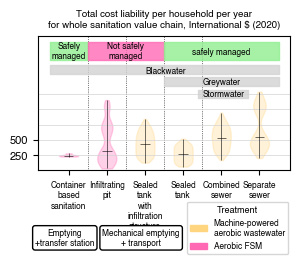

In [12]:
# create canvas to draw figure
fig, ax = plt.subplots(figsize=(3.25, 1.75))



# put background color as white
fig.patch.set_facecolor('white') 

# set Y axis ranges
ax.set_ylim(ytick_range[0], ytick_range[1])  
ax.set_yticks(np.arange(250, 750,250))

# draw horizontal lines for each 250 Int$
for ylabel in np.arange(0,1500,250):
    ax.axhline(y=ylabel, color='lightgray', linewidth=0.5)

ax.axvline(x=1.5, color='k', linestyle=':', linewidth=0.5, zorder=0)
ax.axvline(x=2.5, color='k', linestyle=':', linewidth=0.5, zorder=0)
ax.axvline(x=3.5, color='k', linestyle=':', linewidth=0.5, zorder=0)
ax.axvline(x=4.5, color='k', linestyle=':', linewidth=0.5, zorder=0)

    
# Loop by the above 10 groups
for j, group in enumerate(groups):
    label = group_labels[j]
    tachs = group[1]['tach']
    color = group[1]['color'][0]
    position = j + 1
    drawBoxplot(ax, tachs, position, color)
    
# draw labels for xticks.
# only show emptying & tranport in x axis label
xtick_labels = [ label for label in group_labels ]
ax.set_xticks(np.arange(len(xtick_labels)) + 1)
ax.set_xticklabels(xtick_labels,  rotation=0, ha='center', fontsize=6)

ax.fill_between([0.5, 1.5], 1800, 2100, color='#90EE90', alpha=0.8)
ax.fill_between([1.5, 3.5], 1800, 2100, color='#FF69B4', alpha=0.8)
ax.fill_between([3.5, 6.5], 1800, 2100, color='#90EE90', alpha=0.8)
ax.fill_between([0.5, 6.5], 1580, 1720, color='lightgray', alpha=0.8)
ax.fill_between([3.5, 6.5], 1380, 1520, color='lightgray', alpha=0.8)
ax.fill_between([4.4, 5.7], 1180, 1320, color='lightgray', alpha=0.8)

ax.text(1, 1950, 'Safely\nmanaged', fontsize=6, ha='center', va='center')
ax.text(2.5, 1950, 'Not safely\nmanaged', fontsize=6, ha='center', va='center')
ax.text(5.0, 1930, 'safely managed', fontsize=6, ha='center', va='center')

ax.text(3, 1630, 'Blackwater', fontsize=6, ha='left', va='center')
ax.text(4.5, 1450, 'Greywater', fontsize=6, ha='left', va='center')
ax.text(4.5, 1250, 'Stormwater', fontsize=6, ha='left', va='center')


# draw legend
legend_labels = [
    'Machine-powered\naerobic wastewater',
    'Aerobic FSM',
]
legend_colors = [colors[0], colors[2]]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
legend = ax.legend(handles=legend_patches, loc='upper right', fontsize=6, bbox_to_anchor=(1.01, -0.2))
legend.set_title("Treatment", prop={'size': 6.5})

plt.title('Total cost liability per household per year\nfor whole sanitation value chain, International $ (2020)', fontsize=7)

bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=1.0)

ax.text(0.9, -1100, 'Emptying\n+transfer station', fontsize=6, ha='center', va='center', bbox=bbox_props)
ax.text(2.9, -1100, 'Mechanical emptying\n+ transport', fontsize=6, ha='center', va='center', bbox=bbox_props)

# save figures as PDF and PNG
plt.savefig(file_path, format="pdf", dpi=dpi, transparent=True, bbox_inches='tight')
plt.savefig(f"{file_path}.png", format="png", dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()